In [1]:
# %pip install numpy
# %pip install matplotlib
# %pip install scipy
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn
# %pip install nltk

In [1]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import torch
from torch.utils.data import DataLoader, TensorDataset

from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(2024)

In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_train.describe()

,message,label
count,25000,25000
unique,24904,2
top,How has this piece of crap stayed on TV this l...,neg
freq,3,12500


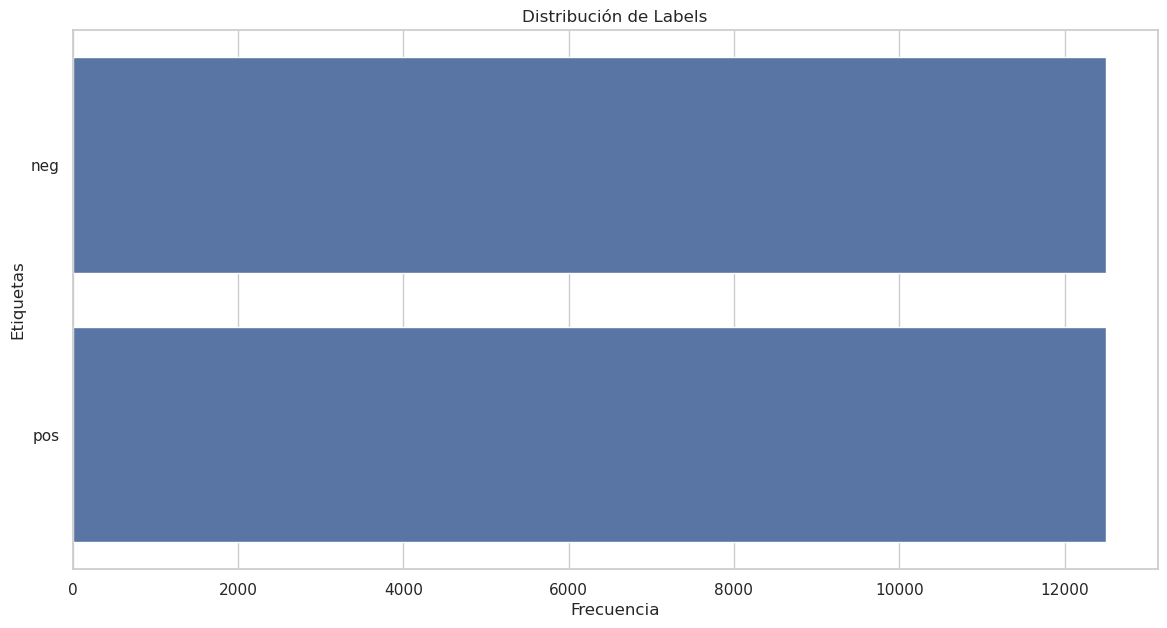

In [4]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.countplot(df_train.iloc[:, 1], order=df_train.iloc[:, 1].value_counts().index)

# Configurar los títulos y etiquetas
plt.title('Distribución de Labels')
plt.xlabel('Frecuencia')
plt.ylabel('Etiquetas')

# Mostrar la gráfica
plt.show()

# 2. Prepocesamiento
- Tokenizar
- Eliminar stopwords
- Part-Of-Speech tag
- Lematización

In [58]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Lista de palabras de negación sintáctica
syntactic_negations = set(["no", "not", "none", "never", "neither", "nor", "cannot", "can't"])

# Lista de prefijos de negación morfológica
morphological_prefixes = ["un", "in", "dis", "im", "ir", "non", "anti"]

def tokenize(text):
    # return [word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]
    return [word for word in word_tokenize(text.lower()) if word.isalpha()]

def pos_tagging(tokens):
    return pos_tag(tokens)

# Función para convertir etiquetas de POS de NLTK a etiquetas de WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def mark_negations(tokens):
    # Marca las palabras y frases con negaciones.
    negated_tokens = []
    negation = False
    for token in tokens:
        if token in syntactic_negations:
            negation = True
            negated_tokens.append(token)
        elif negation:
            if token in stop_words:
                negated_tokens.append(token)
            else:
                negated_tokens.append(token + "_NEG")
                negation = False
        else:
            negated_tokens.append(token)
    
    return negated_tokens

# def mark_negations(tokens):
#     negated_tokens = []
#     negation = False
#     for i, token in enumerate(tokens):
#         if token in syntactic_negations:
#             negation = True
#             negated_tokens.append(token)
#         elif negation:
#             if token in stop_words:
#                 negated_tokens.append(token)
#             else:
#                 negated_tokens.append(token + "_NEG")
#                 # Detectar doble negación
#                 if i > 0 and tokens[i - 1] == "not":
#                     negated_tokens[i] = tokens[i]
#                 negation = False
#         else:
#             negated_tokens.append(token)
    
#     return negated_tokens


def handle_morphological_negations(tokens):
    # Marca las palabras con prefijos de negación morfológica.
    negated_tokens = []
    for token in tokens:
        for prefix in morphological_prefixes:
            if token.startswith(prefix):
                root = token[len(prefix):]
                negated_tokens.append(root + "_NEG")
                break
        else:
            negated_tokens.append(token)
    
    return negated_tokens

def handle_double_negations(tokens):
    negated_tokens = []
    for i, token in enumerate(tokens):
        if token.endswith("_NEG_NEG"):
            negated_tokens.append(token[:-8])
        else:
            negated_tokens.append(token)
    
    return negated_tokens

def lemmatize(pos_tags):
    return [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos) or wordnet.NOUN) for word, pos in pos_tags]

def preprocess(df):
    df['tokens'] = df['message'].apply(tokenize)
    df['tokens'] = df['tokens'].apply(mark_negations)
    df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
    df['tokens'] = df['tokens'].apply(handle_morphological_negations)
    df['tokens'] = df['tokens'].apply(handle_double_negations)
    df['pos_tags'] = df['tokens'].apply(pos_tagging)
    df['lemmas'] = df['pos_tags'].apply(lemmatize)
    return df

[nltk_data] Downloading package punkt to /home/adrianjcz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adrianjcz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adrianjcz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/adrianjcz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [59]:
# Ejemplo de uso
import pandas as pd

data = {'message': ["The audience disliked the actor leading the play.", 
                    "He was not supposed to come.", 
                    "The price of the car is not insignificant."]}

df = pd.DataFrame(data)
processed_df = preprocess(df)

processed_df[['message', 'tokens', 'lemmas']]

,message,tokens,lemmas
0,The audience disliked the actor leading the play.,"[audience, liked_NEG, actor, leading, play]","[audience, liked_NEG, actor, lead, play]"
1,He was not supposed to come.,"[supposed_NEG, come]","[supposed_NEG, come]"
2,The price of the car is not insignificant.,"[price, car, significant]","[price, car, significant]"


In [60]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)
df_train.to_pickle('df_train_processed.pkl')
df_test.to_pickle('df_test_processed.pkl')

### Cargar data una vez preprocesada

In [9]:
df_train = pd.read_pickle('df_train_processed.pkl')
df_submit = pd.read_pickle('df_test_processed.pkl')

In [10]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=2024)

In [12]:
# use tf-idf to vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(max_features=1000)
tfidf = TfidfVectorizer()

x_train = tfidf.fit_transform(df_train['lemmas'].apply(' '.join))
x_test = tfidf.transform(df_test['lemmas'].apply(' '.join))
x_submit = tfidf.transform(df_submit['lemmas'].apply(' '.join))

In [13]:
#enconde de y a valores numericos
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['label'])
y_test = label_encoder.transform(df_test['label'])


#verificar que significa cada valor numerico
label_encoder.classes_

array(['neg', 'pos'], dtype=object)

In [122]:
from sklearn.feature_selection import SelectKBest, chi2

k = 5000  # Número de características a seleccionar, ajusta este valor según sea necesario
chi2_selector = SelectKBest(chi2, k=k)
x_train_chi2 = chi2_selector.fit_transform(x_train, y_train)
x_test_chi2 = chi2_selector.transform(x_test)
x_submit_chi2 = chi2_selector.transform(x_submit)

In [126]:
n_features = x_train_chi2.shape[1]
print(f'Number of features: {n_features}')

Number of features: 5000


# SVM TEST

In [13]:
# fast test with training with svm
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report

# clf = SVC()
# clf.fit(x_train, y_train)

# y_pred = clf.predict(x_test)

# print(classification_report(y_test, y_pred))

## MLP TEST

In [16]:
# Prepare Colab to work with CUDA.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [221]:
#MLP
import torch.nn as nn

#0.84
# INPUT_SIZE = 1000
# OUTPUT_SIZE = 2
# LAYERS = 2
# LAYER_SIZE = 1000


#
# INPUT_SIZE = 1000
INPUT_SIZE = n_features
OUTPUT_SIZE = 2
LAYERS = 10
LAYER_SIZE = 100
DROPOUT_RATE = 0.5

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()

        # Primera capa
        self.layers.append(nn.Linear(INPUT_SIZE, LAYER_SIZE))
        self.layers.append(nn.BatchNorm1d(LAYER_SIZE))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(DROPOUT_RATE))

        # Capas intermedias
        for _ in range(LAYERS):
            self.layers.append(nn.Linear(LAYER_SIZE, LAYER_SIZE))
            self.layers.append(nn.BatchNorm1d(LAYER_SIZE))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(DROPOUT_RATE))

        # Última capa
        self.layers.append(nn.Linear(LAYER_SIZE, OUTPUT_SIZE))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [61]:
def train(model, loss_f, optimizer, epochs, train_loader):
    loss_lista = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = model(x_batch)
            loss = loss_f(y_pred, y_batch)
            epoch_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_epoch_loss = epoch_loss / len(train_loader)
        loss_lista.append(avg_epoch_loss)

        if epoch % 1 == 0:
            print('Epoch {}: train loss: {:.4f}'.format(epoch, avg_epoch_loss))
    return loss_lista

In [19]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

def matriz_confusion(y_test, y_pred, Tipo):
 matrix = confusion_matrix(y_test, y_pred)
 f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index= label_encoder.classes_  , columns=label_encoder.classes_)
 sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
 plt.title("Confusion Matrix - "  + Tipo ), plt.tight_layout()
 plt.xlabel("Predicted")
 plt.ylabel("Real")
 plt.show()
 
# Write your code here
def test(model, x_test, y_test, tipo):
  if tipo == "MLP":
    model.eval()
    with torch.no_grad():
      x_test = x_test.to(device)
      y_test = y_test.to(device)
      y_pred = model(x_test)

      y_pred = torch.argmax(y_pred, dim=1).cpu()
      y_test = y_test.cpu()
  else:
    y_pred = model.predict(x_test)
    
  print(classification_report(y_test, y_pred))
  matriz_confusion(y_test, y_pred,"MLP")

In [238]:
# Modelos
model = MLP().to(device)
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.005)

In [239]:
# x_train_dv = torch.tensor(x_train.toarray(), dtype=torch.float32)
x_train_dv = torch.tensor(x_train_chi2.toarray(), dtype=torch.float32)
y_train_dv = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

print("MLP TRAIN")
loss_list = train(model, loss, optimizer, 10, train_loader)

MLP TRAIN
Epoch 0: train loss: 0.6909
Epoch 1: train loss: 0.4852
Epoch 2: train loss: 0.3655
Epoch 3: train loss: 0.3122
Epoch 4: train loss: 0.2781
Epoch 5: train loss: 0.2417
Epoch 6: train loss: 0.2183
Epoch 7: train loss: 0.2072
Epoch 8: train loss: 0.1830
Epoch 9: train loss: 0.1781


              precision    recall  f1-score   support

           0       0.79      0.94      0.86      2463
           1       0.93      0.75      0.83      2537

    accuracy                           0.85      5000
   macro avg       0.86      0.85      0.84      5000
weighted avg       0.86      0.85      0.84      5000



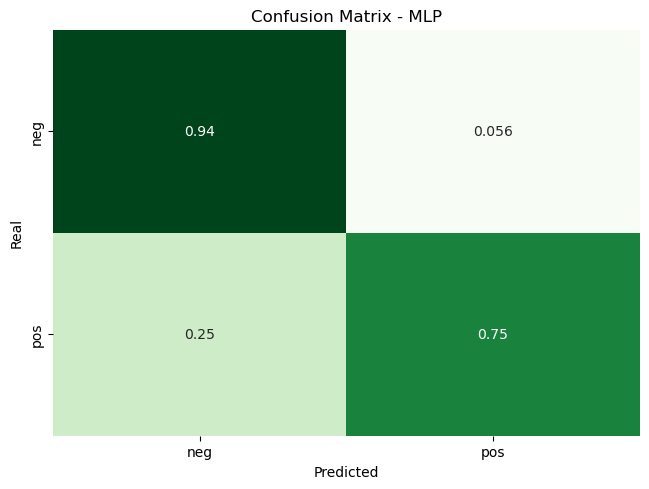

In [240]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
x_test_dv = torch.tensor(x_test_chi2.toarray(), dtype=torch.float32)
y_test_dv = torch.tensor(y_test, dtype=torch.long)

test(model, x_test_dv, y_test_dv, "MLP")

In [213]:
x_submit_t = torch.tensor(x_submit_chi2.toarray(), dtype=torch.float32)
submit_dataset = TensorDataset(x_submit_t)
submit_loader = DataLoader(submit_dataset, batch_size=64, shuffle=False)

all_preds = []
model.eval()
with torch.no_grad():
    for batch in submit_loader:
        batch = batch[0].to(device)
        pred = model(batch)
        pred = torch.argmax(pred, dim=1).cpu()
        all_preds.extend(pred)

label_map = {0: 'neg', 1: 'pos'}
labels = [label_map[label.item()] for label in all_preds]

ids = list(range(len(labels)))
submission_df = pd.DataFrame({'ids': ids, 'label': labels})

submission_df.to_csv('submit.csv', index=False)